# Dropout in Convolutional Layers

## Purpose
We test whether applying dropout in **convolutional layers** helps reduce overfitting differently from FC dropout.  
Comparison: conv dropout vs baseline and vs best FC dropout.
.
The dropout technique we will apply in this notebook is Spatial dropout and not Dropblock (Ghiasi et al, 2018).

It's law that high convolutional layer dropout negatively affects model training, we will observe this.


In [17]:
import os
import sys

current_dir = os.getcwd()
package_path = os.path.abspath(os.path.join(current_dir, '..'))

if package_path not in sys.path:
    sys.path.insert(0, package_path)

In [18]:
# importing all necessary libs and modules.
import torch
from PIL import Image
import matplotlib.pyplot as plt

from config.paths import PathConfig # Path config

from src.model import MiniCNN, ConvBlock, FCBlock
from src.train import trainModel
from src.data import CustomDataset, load_cifar_10_data, check_data_loading, Loader, class_to_idx
from src.visualizations import plotFmaps_and_activationHist, plotCurves
from src.utils import unpickle, loadWeights, readJson, genError, saveHistory, evalModel

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
paths = PathConfig("regularization-ml", "regularization-data")
PROJECT_DIR = paths.project
DATA_DIR = paths.data
BASE_DIR = paths.root

## Dataset
Same dataset/preprocessing as baseline. Same preprocessing techniques.

In [ ]:
""" If using Colab, uncomment this
# Copy once from Drive
!cp $DATA_DIR/cifar-10-python.tar.gz /content/

# Extract locally
!mkdir /content/dataset/
!tar -xzf /content/cifar-10-python.tar.gz -C /content/dataset/
"""

In [ ]:
""" If running on local, uncomment this
!mkdir $DATA_DIR/dataset/
!tar -xzf $DATA_DIR/cifar-10-python.tar.gz -C $DATA_DIR/dataset/
"""

In [24]:
LOCAL_DATA = f"{DATA_DIR}/dataset" # path to cifar-10 dataset
train_data, train_labels, val_data, val_labels, test_data, test_labels = load_cifar_10_data(LOCAL_DATA)

In [25]:
# Creates train, test, and val loaders
train_loader, val_loader, test_loader = Loader(train_data, train_labels, val_data, val_labels, test_data, test_labels)

Starting Data Loading...
⚠️  CUDA not available, using CPU
📁 Loading datasets...
✅ Datasets loaded successfully
Training samples: 40000
Validation samples: 10000
Batch size: 64
🔍 Testing data loading...
✅ Train batch shape: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])
   Input range: [-1.989, 2.126]
   Label range: [0, 9]
✅ Val batch shape: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])


## Model Definition
Baseline CNN + dropout applied after convolutional layers.  
- Dropout probabilities tested: p ∈ {0.1, 0.3, 0.5}
- We keep the probabilities low, as per our initial bias.

## Training Setup
Identical to baseline.
Only differences:
- Dropout added after conv layer 3.
- Early stopping patience set back to it's default of 7.




---
---

## Exp 1: Conv dropout p = 0.1

We place the dropout layer in the third convolution block with no pooling.

In [ ]:
# Defining the layers for the baseline model
base_conv_layers = [
    ConvBlock(3, 64, pool=False),
    ConvBlock(64, 64),
    ConvBlock(64, 128, pool=False, dropout=True, drop_val=0.1),
    ConvBlock(128, 128)
]

base_fc_layers = [
    FCBlock(128, 64),
    torch.nn.Linear(64, 10)
]

conv_1_model = MiniCNN(base_conv_layers, base_fc_layers)

In [ ]:
""" Uncomment this to train the model
history_conv1 = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
model_type = "conv0.1"
path = f"{DATA_DIR}/weights"
conv_1_model = trainModel(conv_1_model, history_conv1, train_loader, val_loader, model_type, path)
"""

In [ ]:
""" This saves history
history_path = f"../logs/conv0.1.json"
saveHistory(history_conv1, history_path) # Saves the training metadata to a json file
"""

The model trained for 69 epochs before early stopping was triggered.

In [ ]:
visuals1 = f"../visualizations/conv0.1"
weights_path = f"{DATA_DIR}/weights/conv0.1.pth"
conv1model = loadWeights(conv_1_model, weights_path)

In [ ]:
conv1_json = f"../logs/conv0.1.json"
conv1_data = readJson(conv1_json)

### Loss and Accuracy Curves
Nothing of great significance to show, just nice looking curves.

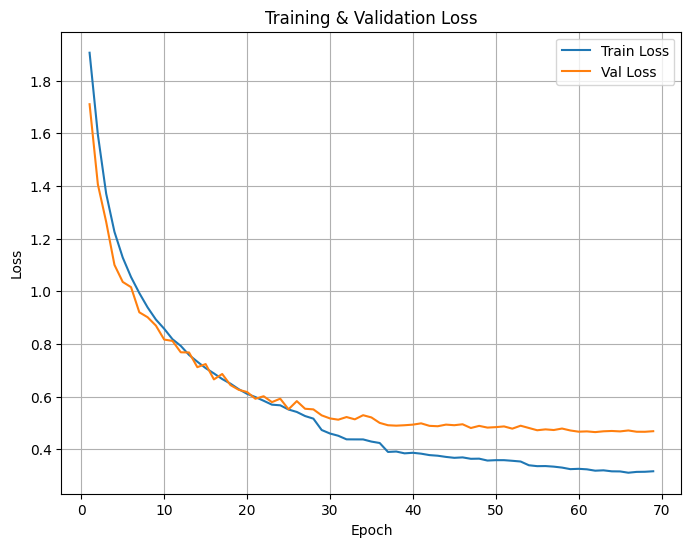

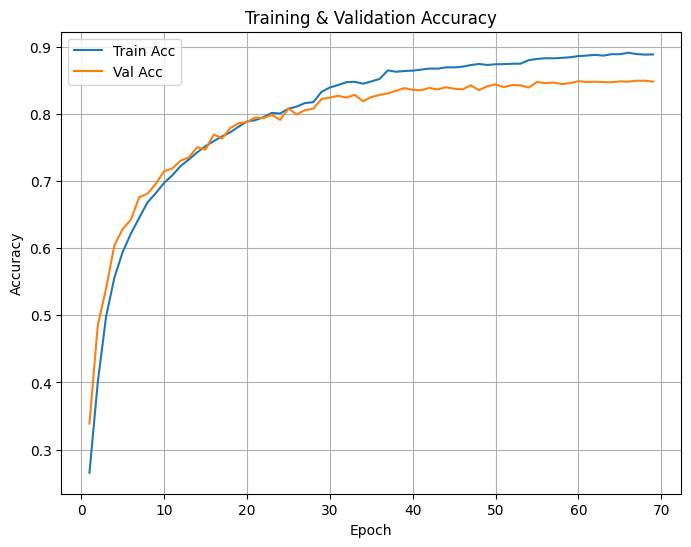

In [ ]:
train_losses_conv1 = conv1_data["train_loss"]
val_losses_conv1 = conv1_data["val_loss"]
train_accs_conv1 = conv1_data["train_acc"]
val_accs_conv1 = conv1_data["val_acc"]
plotCurves(train_losses_conv1, val_losses_conv1, train_accs_conv1, val_accs_conv1, visuals1)

Accuracy: 0.833
              precision    recall  f1-score   support

           0     0.8495    0.8520    0.8507      1000
           1     0.9241    0.9010    0.9124      1000
           2     0.7500    0.8160    0.7816      1000
           3     0.7253    0.6680    0.6955      1000
           4     0.8039    0.7910    0.7974      1000
           5     0.7578    0.7820    0.7697      1000
           6     0.8469    0.8520    0.8495      1000
           7     0.8700    0.8500    0.8599      1000
           8     0.9206    0.9040    0.9122      1000
           9     0.8857    0.9140    0.8996      1000

    accuracy                         0.8330     10000
   macro avg     0.8334    0.8330    0.8328     10000
weighted avg     0.8334    0.8330    0.8328     10000

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequentia

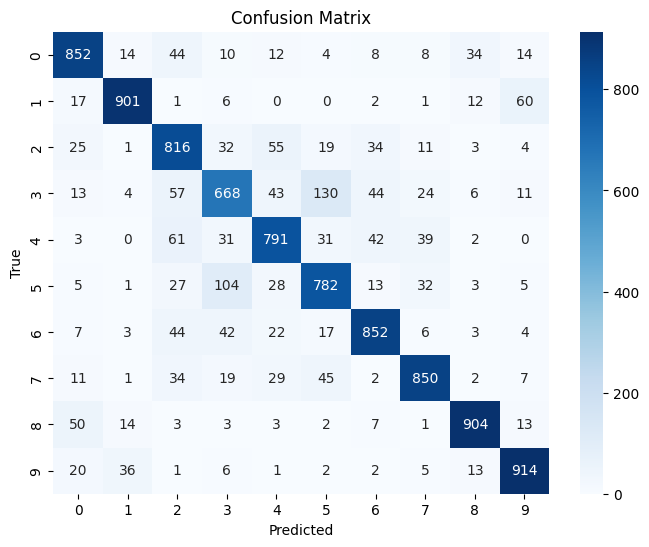

In [ ]:
evalModel(conv1model, visuals1, test_loader) # Best Performer!




---
---

## Exp 2: Conv dropout p = 0.3
Same data preprocessing.

In [ ]:
# Defining the layers for the baseline model
base_conv_layers = [
    ConvBlock(3, 64, pool=False),
    ConvBlock(64, 64),
    ConvBlock(64, 128, pool=False, dropout=True, drop_val=0.3),
    ConvBlock(128, 128)
]

base_fc_layers = [
    FCBlock(128, 64),
    torch.nn.Linear(64, 10)
]

conv_3_model = MiniCNN(base_conv_layers, base_fc_layers)

In [ ]:
"""
history_conv3 = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
model_type = "conv0.3"
path = f"{DATA_DIR}/weights"
conv_3_model = trainModel(conv_3_model, history_conv3, train_loader, val_loader, model_type, path)
"""

In [ ]:
"""
history_path = f"../logs/conv0.3.json"
saveHistory(history_conv3, history_path) # Saves the training metadata to a json file
"""

In [ ]:
visuals3 = f",,/visualizations/conv0.3"
weights_path = f"{DATA_DIR}/weights/conv0.3.pth"
conv3model = loadWeights(conv_3_model, weights_path)

Accuracy: 0.8152
              precision    recall  f1-score   support

           0     0.8139    0.8180    0.8160      1000
           1     0.9281    0.9040    0.9159      1000
           2     0.7202    0.7360    0.7280      1000
           3     0.6975    0.6710    0.6840      1000
           4     0.7600    0.7980    0.7785      1000
           5     0.7679    0.7510    0.7594      1000
           6     0.8217    0.8480    0.8346      1000
           7     0.8724    0.8270    0.8491      1000
           8     0.8826    0.8950    0.8888      1000
           9     0.8906    0.9040    0.8973      1000

    accuracy                         0.8152     10000
   macro avg     0.8155    0.8152    0.8152     10000
weighted avg     0.8155    0.8152    0.8152     10000

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequenti

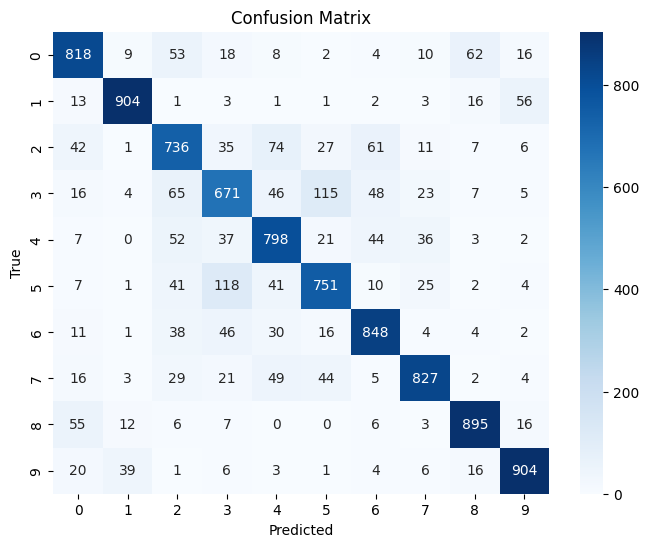

In [ ]:
evalModel(conv3model, visuals3, test_loader)




---
---

## Exp 3: Conv dropout p = 0.5

In [ ]:
base_conv_layers5 = [
    ConvBlock(3, 64, pool=False),
    ConvBlock(64, 64),
    ConvBlock(64, 128, pool=False, dropout=True, drop_val=0.5),
    ConvBlock(128, 128)
]

base_fc_layers5 = [
    FCBlock(128, 64),
    torch.nn.Linear(64, 10)
]

conv_5_model = MiniCNN(base_conv_layers5, base_fc_layers5)

In [ ]:
"""
history_conv5 = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
model_type = "conv0.5"
path = f"{DATA_DIR}/weights"
conv_5_model = trainModel(conv_5_model, history_conv5, train_loader, val_loader, model_type, path)
"""

In [ ]:
"""
history_path = f"../logs/conv0.5.json"
saveHistory(history_conv5, history_path) # Saves the training metadata to a json file
"""

Model trained for 70 epochs, early stopping not triggered.

In [ ]:
visuals5 = f"../visualizations/conv0.5"
weights_path = f"{DATA_DIR}/weights/conv0.5.pth"
conv5model = loadWeights(conv_5_model, weights_path)

In [ ]:
conv5_json = f"../logs/conv0.5.json"
conv5_data = readJson(conv5_json)

### Loss and Accuracy Curves
Very dodgy looking curves, validation loss never quite plateaus, both validation accuracy and loss are consistently better than the training sets'.

The model is behaving as intended: the regularization is successfully making it generalize well, even at the expense of its immediate training performance.

This is an effect of strong regularization.

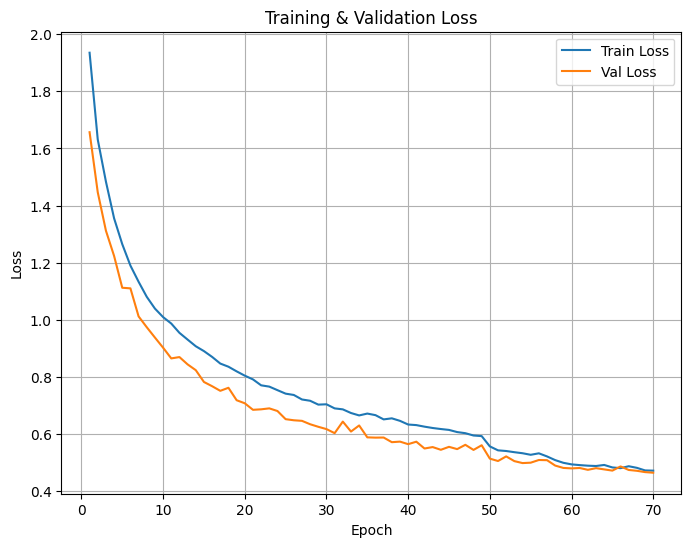

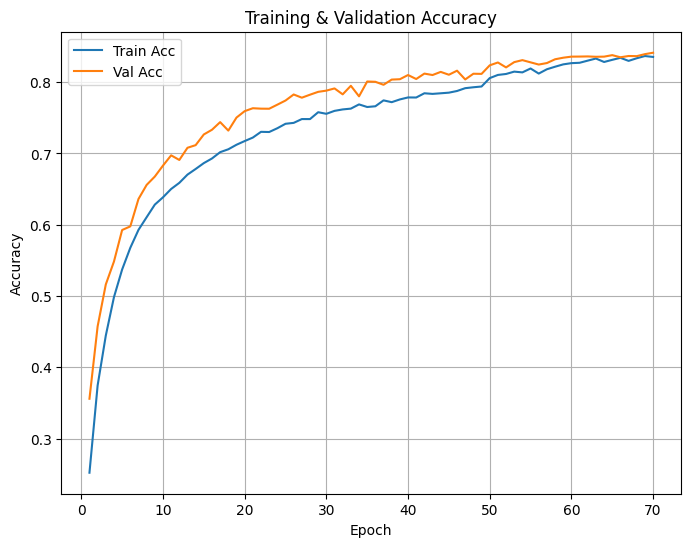

In [ ]:
train_losses_conv5 = conv5_data["train_loss"]
val_losses_conv5 = conv5_data["val_loss"]
train_accs_conv5 = conv5_data["train_acc"]
val_accs_conv5 = conv5_data["val_acc"]
plotCurves(train_losses_conv5, val_losses_conv5, train_accs_conv5, val_accs_conv5, visuals5)

### Feature Maps
We observe the salt and pepper effect of dropout in the feature maps. Very pretty.

The activation histogram showcases that almost layer neuron activations cluster around 0, with a few outliers.

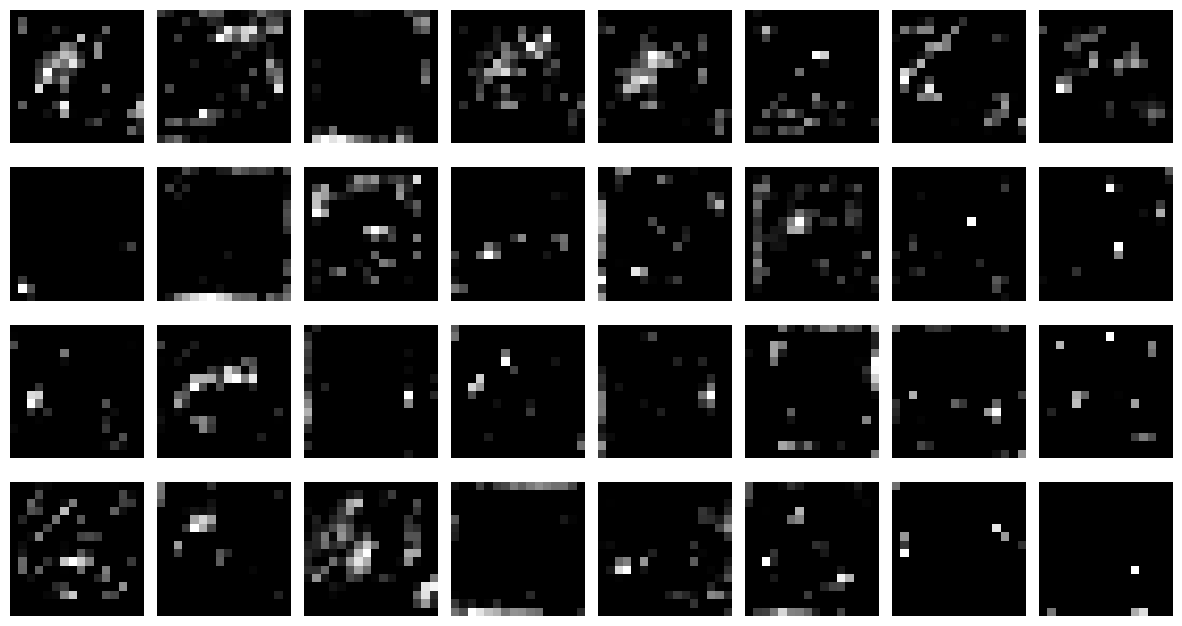

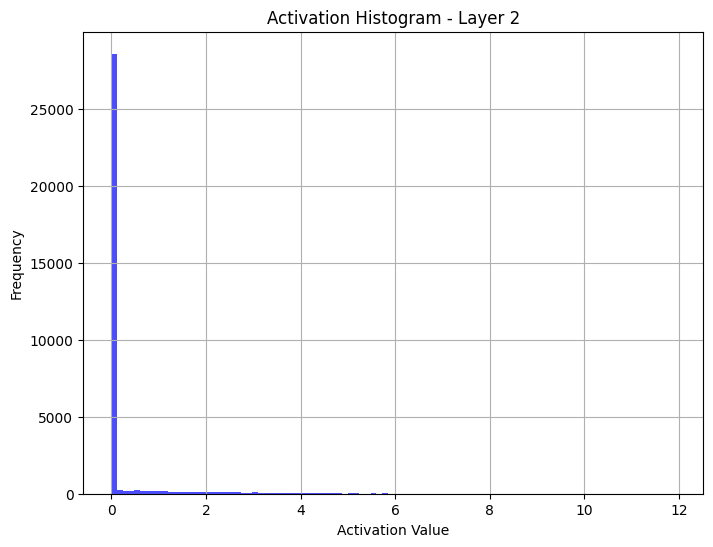

In [ ]:
plotFmaps_and_activationHist(conv5model, visuals5, val_loader, layer=2)

## Results
| Model                | Val Acc | Test Acc |  
|----------------------|---------|----------|  
| Baseline             | 82.4%   | 81.8%    |  
| FC Dropout (p=0.5)   | 85.0%   | 83.3%    |
| Conv Dropout (p=0.3) | 84.1%   | 81.4%    |  
| Conv Dropout (p=0.5) | 84.1%   | 81.0%    |  

## Discussion
- Conv dropout helped, and very suprisingly higher than in FC layers.  
- Too much conv dropout (p=0.5) degraded feature extraction quality.
- We observed this as well in the FC experiment, dropout range is best kept moderate and for conv layers, it seems, it's best when low as convolutional layers need their rich spatial features retained.


## Conclusion
Convolution dropout improved model accuracy (~3%), but only when kept low.
